In [1]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, UpSampling2D
from tensorflow.keras.layers import ZeroPadding2D, AveragePooling2D, GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import Conv2D, Input, Flatten, Add, Dropout, Activation
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras import backend as K
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, accuracy_score

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# to ignore displaying warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:
from glob import glob
from tqdm import tqdm

class Utils:
    
    def __init__(self, path):
        self.__glob(path)
    
    def __glob(self, path):
        """loading data using glob"""
        self.path_lsts = [p for p in glob(path, recursive=True) if p.endswith('.png')]
        print("Size of images:", len(self.path_lsts))

    def display_images(self, figure_row=4, figure_cols=4):
        """Display images """
        f, ax = plt.subplots(nrows= figure_row, ncols=figure_cols, 
                             figsize=(figure_row*figure_cols, figure_row*figure_cols)) 
        number_of_images = figure_row * figure_cols
        images = []
        for i in range(figure_row):
            for j in range(figure_cols):
                while True:
                    rand = np.random.randint(0, len(self.path_lsts)-1)
                    if rand not in images:
                        images.append(rand)
                        break
                image=cv2.imread(self.path_lsts[rand])
                ax[i, j].imshow(image, resample=True, cmap='gray')
                ax[i, j].set_title("Class-"+ self.path_lsts[rand][-5], fontsize=16)
        plt.tight_layout()
        plt.show()
        print("Original Image Shape:",image.shape)
        
    def load_images(self, dsize = (64, 64), n_images = -1):
        """loading images"""
        images_path = self.path_lsts[:n_images]
        self.X_image, self.y_image = [], []
        
        for path in tqdm(images_path):
            image = load_img(path, target_size=dsize)
            self.X_image.append(image)
            #self.X_image.append(img_to_array(image)/255.0)
            self.y_image.append(int(path[-5]))
            
    def summary(self):
        """Display summary of data"""
        print('Total number of images: {}'.format(len(self.X_image)))
        print('Number of IDC(-) Images: {}'.format(len(self.X_image)-np.sum(self.y_image)))
        print('Number of IDC(+) Images: {}'.format(np.sum(self.y_image)))
        #print('Image shape (Width, Height, Channels): {}'.format(self.X_image[0].shape))
    
    def get_images(self):
        """Return images"""
        return np.array(self.X_image), np.array(self.y_image)

In [3]:
#Helper Methods
import pickle
def save_pkl(path, data):
    '''save pickle data into specified path '''
    with open(path, "wb") as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)

def load_pkl(path):
    '''load pickle data from specified path'''
    with open(path, "rb") as f:
        pkl = pickle.load(f)
    return pkl

Size of images: 277522


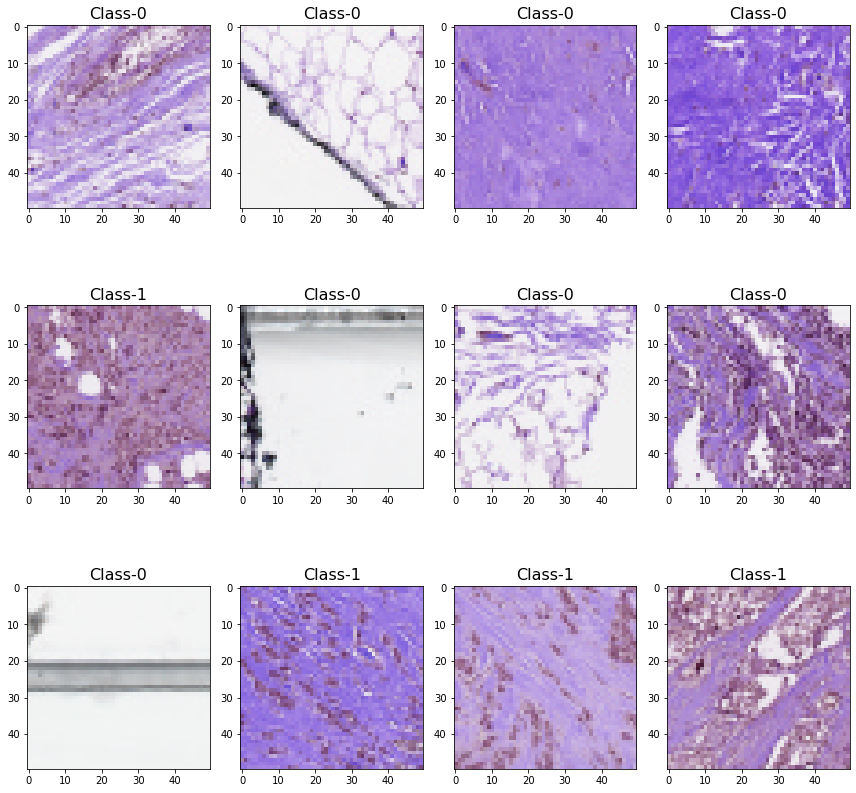

Original Image Shape: (50, 50, 3)


In [4]:
#path to input dataset pattern for glob
path = 'IDC_regular_ps50_idx5/*/*/*'

#initialize utils
utils = Utils(path)

#display a few images randomly
utils.display_images(figure_row=3)

In [5]:
# Load the data if LOAD is True
dsize = (32, 32)
LOAD = True  # Set to True if you want to load the data

if LOAD:
    path = 'IDC_regular_ps50_idx5/dataset.pkl'
    utils.load_images(dsize=dsize, n_images=-1)
    X, y = utils.X_image, utils.y_image
    loaded_dataset = {"X": X, "Y": y}
    save_pkl(path, loaded_dataset)
    utils.summary()
    
# Define preprocess function
def preprocess(images, y, normalize=True, size=-1):
    for i in tqdm(range(len(images[:size]))):
        if normalize:
            img = img_to_array(images[i]) / 255.0
        else:
            img = img_to_array(images[i])
        images[i] = img
    return np.array(images), np.array(y)

# Call preprocess function after loading the data
if LOAD:
    X, y = preprocess(X, y, size=-1)
    X_train, y_train = X[:150000], y[:150000]
    X_test, y_test = X[150001:200000], y[150001:200000]


100%|████████████████████████████████████████████████████████████████████████| 277521/277521 [04:08<00:00, 1116.81it/s]


Total number of images: 277521
Number of IDC(-) Images: 198737
Number of IDC(+) Images: 78784


100%|███████████████████████████████████████████████████████████████████████| 277520/277520 [00:18<00:00, 15027.60it/s]


### ResNet50

In [7]:
def identity_block(X, f, filters, stage, block):    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1, 1), 
               padding = 'valid', name = conv_name_base + '2a', 
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), 
               padding = "same", name = conv_name_base + "2b", 
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), 
               padding = "valid", name = conv_name_base + "2c", 
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def convolutional_block(X, f, filters, stage, block, s = 2):    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
    X_shortcut = X

    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', 
               padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(F2, (f, f), strides = (1,1), name = conv_name_base + '2b', 
               padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(F3, (1,1), strides = (1,1), name = conv_name_base + '2c', 
               padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    X_shortcut = Conv2D(F3, (1,1), strides = (s, s), padding = "valid", name = conv_name_base + "1", 
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [9]:
def ResNet50(input_shape = (32, 32, 3), classes = 2):    
    X_input = Input(input_shape)
    
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    #X = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3 
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    
    X = AveragePooling2D()(X)
    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='sigmoid', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')
    
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    
    return model

In [10]:
model = ResNet50()

model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 38, 38, 3)            0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1 (Conv2D)              (None, 16, 16, 64)           9472      ['zero_padding2d[0][0]']      
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1[0][0]']        

                                                                                                  
 bn2c_branch2c (BatchNormal  (None, 16, 16, 256)          1024      ['res2c_branch2c[0][0]']      
 ization)                                                                                         
                                                                                                  
 add_2 (Add)                 (None, 16, 16, 256)          0         ['bn2c_branch2c[0][0]',       
                                                                     'activation_6[0][0]']        
                                                                                                  
 activation_9 (Activation)   (None, 16, 16, 256)          0         ['add_2[0][0]']               
                                                                                                  
 res3a_branch2a (Conv2D)     (None, 8, 8, 128)            32896     ['activation_9[0][0]']        
          

                                                                                                  
 activation_18 (Activation)  (None, 8, 8, 512)            0         ['add_5[0][0]']               
                                                                                                  
 res3d_branch2a (Conv2D)     (None, 8, 8, 128)            65664     ['activation_18[0][0]']       
                                                                                                  
 bn3d_branch2a (BatchNormal  (None, 8, 8, 128)            512       ['res3d_branch2a[0][0]']      
 ization)                                                                                         
                                                                                                  
 activation_19 (Activation)  (None, 8, 8, 128)            0         ['bn3d_branch2a[0][0]']       
                                                                                                  
 res3d_bra

 ization)                                                                                         
                                                                                                  
 activation_28 (Activation)  (None, 4, 4, 256)            0         ['bn4c_branch2a[0][0]']       
                                                                                                  
 res4c_branch2b (Conv2D)     (None, 4, 4, 256)            590080    ['activation_28[0][0]']       
                                                                                                  
 bn4c_branch2b (BatchNormal  (None, 4, 4, 256)            1024      ['res4c_branch2b[0][0]']      
 ization)                                                                                         
                                                                                                  
 activation_29 (Activation)  (None, 4, 4, 256)            0         ['bn4c_branch2b[0][0]']       
          

 res4f_branch2c (Conv2D)     (None, 4, 4, 1024)           263168    ['activation_38[0][0]']       
                                                                                                  
 bn4f_branch2c (BatchNormal  (None, 4, 4, 1024)           4096      ['res4f_branch2c[0][0]']      
 ization)                                                                                         
                                                                                                  
 add_12 (Add)                (None, 4, 4, 1024)           0         ['bn4f_branch2c[0][0]',       
                                                                     'activation_36[0][0]']       
                                                                                                  
 activation_39 (Activation)  (None, 4, 4, 1024)           0         ['add_12[0][0]']              
                                                                                                  
 res5a_bra

                                                                     'activation_45[0][0]']       
                                                                                                  
 activation_48 (Activation)  (None, 2, 2, 2048)           0         ['add_15[0][0]']              
                                                                                                  
 average_pooling2d (Average  (None, 1, 1, 2048)           0         ['activation_48[0][0]']       
 Pooling2D)                                                                                       
                                                                                                  
 flatten (Flatten)           (None, 2048)                 0         ['average_pooling2d[0][0]']   
                                                                                                  
 fc2 (Dense)                 (None, 2)                    4098      ['flatten[0][0]']             
          

In [11]:
ResNet50_history = model.fit(np.stack(X_train),  y_train, validation_split=0.1, 
              epochs=10, batch_size=32, verbose=1)

Epoch 1/10
4219/4219 [==============================] - 13404s 3s/step - loss: 0.4291 - accuracy: 0.8263 - val_loss: 0.5465 - val_accuracy: 0.8159
Epoch 2/10
4219/4219 [==============================] - 40771s 10s/step - loss: 0.4048 - accuracy: 0.8268 - val_loss: 0.6679 - val_accuracy: 0.7901
Epoch 3/10
4219/4219 [==============================] - 10607s 3s/step - loss: 0.3650 - accuracy: 0.8434 - val_loss: 0.3865 - val_accuracy: 0.8461
Epoch 4/10
4219/4219 [==============================] - 10790s 3s/step - loss: 0.3574 - accuracy: 0.8470 - val_loss: 0.3622 - val_accuracy: 0.8515
Epoch 5/10
4219/4219 [==============================] - 11656s 3s/step - loss: 0.3428 - accuracy: 0.8529 - val_loss: 0.3563 - val_accuracy: 0.8601
Epoch 6/10
4219/4219 [==============================] - 10026s 2s/step - loss: 0.3287 - accuracy: 0.8592 - val_loss: 0.3916 - val_accuracy: 0.8393
Epoch 7/10
4219/4219 [==============================] - 9842s 2s/step - loss: 0.3219 - accuracy: 0.8627 - val_loss: 0

In [12]:
y_test_pred = model.predict(np.stack(X_test))

y_test_pred = np.argmax(y_test_pred, axis=1)

acc, f1, precision, recall = accuracy_score(y_test, y_test_pred),\
                             f1_score(y_test, y_test_pred), \
                             precision_score(y_test, y_test_pred), \
                             recall_score(y_test, y_test_pred)

print("Accuracy:", acc)
print("F1-Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

1563/1563 [==============================] - 566s 356ms/step
Accuracy: 0.8660373207464149
F1-Score: 0.7885598838310499
Precision: 0.7969627360898418
Recall: 0.7803323753592403


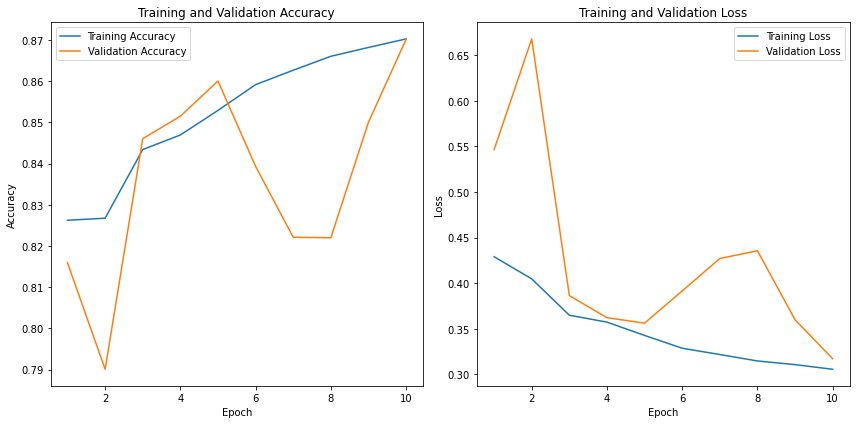

In [14]:
import matplotlib.pyplot as plt

# Extract the training and validation accuracy and loss values from the History object
train_accuracy = ResNet50_history.history['accuracy']
train_loss = ResNet50_history.history['loss']
val_accuracy = ResNet50_history.history['val_accuracy']
val_loss = ResNet50_history.history['val_loss']

# Create a list of epochs for x-axis
epochs = range(1, len(train_accuracy) + 1)

# Plot the training and validation accuracy curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot the training and validation loss curves
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
